## Only Adaptive learned matrix

In [46]:
import wandb
api = wandb.Api()

for boolean in [True, False]:
    print("Apt only", str(boolean))
    runs = api.runs("beyersito/Graph-WaveNet", {"config.aptonly": boolean})
    print("Found %i" % len(runs))
    loss = []
    for run in runs:
        if run.state == "finished":
            if "best_valid_loss" in run.summary:
                loss.append(run.summary.best_valid_loss)
    print(min(loss), max(loss))
    
    
for boolean in [True, False]:
    print("Apt only", str(boolean))
    runs = api.runs("beyersito/Graph-WaveNet", "$and": [{"config.aptonly": False}, {"config.addaptadj": True}]})
    print("Found %i" % len(runs))
    loss = []
    for run in runs:
        if run.state == "finished":
            if "best_valid_loss" in run.summary:
                loss.append(run.summary.best_valid_loss)
    print(min(loss), max(loss))

Apt only True
Found 4
1.3793 1.3979
Apt only False
Found 13
1.3663 1.5291


In [42]:
from util import build_model
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns

runs = api.runs("beyersito/Graph-WaveNet", {"$and": [{"config.aptonly": False}, {"config.addaptadj": True}]})
# runs = api.runs("beyersito/Graph-WaveNet", {"config.aptonly": False})

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
    
    
def plot_adapt(engine):

    nodevec1 = engine.model.nodevec1
    nodevec2 = engine.model.nodevec2

    with torch.no_grad():
        adp = F.softmax(F.relu(torch.mm(nodevec1, nodevec2)), dim=1)
    adp = adp.cpu().detach().numpy()

#     print(adp[stationIdToIndex(60, st_df), stationIdToIndex(69, st_df)])
#     ax_labels = [st_df.iloc[i].id for i in range(adp.shape[0])]

#     adp[adp < 0.1] = 0

    n_points = 4
    ind = adp.argsort(axis=None)[-n_points:] ## pick the largest n_points

    topind = np.unravel_index(ind, adp.shape)
    print("topind", list(zip(*topind)))
    values = np.take(adp, ind)
    print("values", values)
#     print([(stations_ids[i], stations_ids[j]) for (i, j) in zip(*topind)])
    return adp
#     print(sns.heatmap(adp, cmap="YlGnBu"))
#                 , xticklabels=ax_labels, yticklabels=ax_labels)
    
adps = []
for run in runs:
    if run.state == "finished":
        args = dotdict(run.config)
        args.device = 'cpu'
        engine, scaler, dataloader, adj_mx = build_model(args)
        save = run.summary.save_location
        run.file(save.rsplit('/', 1)[-1]).download(replace=True)
        try:
            engine.model.load_state_dict(torch.load(save, map_location=torch.device('cpu')))
            adp = plot_adapt(engine)
            adps.append(adp)  
        except:
            pass

{'data': 'data/SF-BIKE-60min/', 'nhid': 32, 'save': 'experiment/sf-bike/sf-bike', 'expid': 4, 'device': 'cpu', 'epochs': 30, 'in_dim': 2, 'adjdata': 'data/SF-BIKE-60min/adj_dist.pkl', 'adjtype': 'doubletransition', 'aptonly': False, 'dropout': 0.3, 'gcn_bool': True, 'addaptadj': True, 'num_nodes': 59, 'randomadj': True, 'batch_size': 64, 'seq_length': 12, 'print_every': 50, 'weight_decay': 0.0001, 'learning_rate': 0.001}
topind [(15, 40), (42, 58), (14, 51), (7, 49)]
values [0.61462283 0.6189593  0.6307313  0.6958052 ]
{'data': 'data/SF-BIKE-60min/', 'nhid': 32, 'save': 'experiment/sf-bike/sf-bike', 'expid': 4, 'device': 'cpu', 'epochs': 30, 'in_dim': 2, 'adjdata': 'data/SF-BIKE-60min/adj_dist.pkl', 'adjtype': 'doubletransition', 'aptonly': False, 'dropout': 0.3, 'gcn_bool': True, 'addaptadj': True, 'num_nodes': 59, 'randomadj': True, 'batch_size': 64, 'seq_length': 12, 'print_every': 50, 'weight_decay': 0.0001, 'learning_rate': 0.001}
{'data': 'data/SF-BIKE-60min/', 'nhid': 32, 'save'

(3, 59, 59)


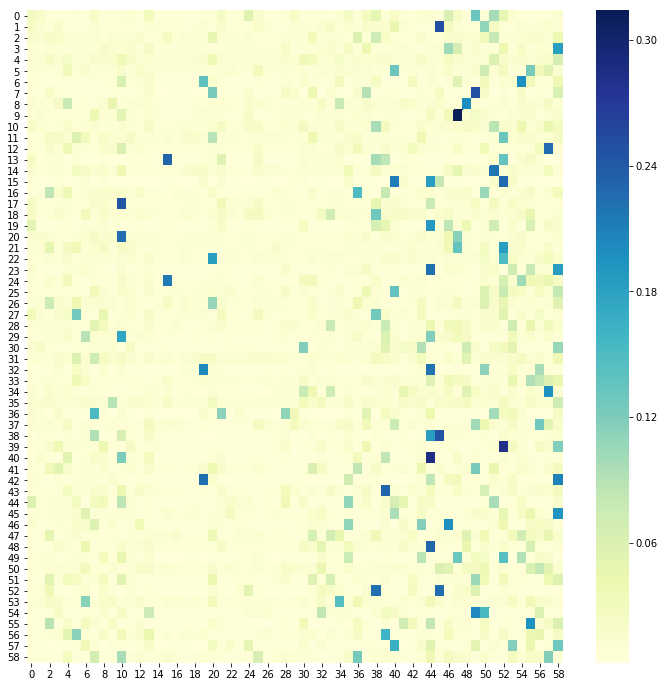

In [43]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,12

adps = np.asarray(adps)
print(adps.shape)
sns.heatmap(np.mean(adps, axis=0), cmap="YlGnBu")

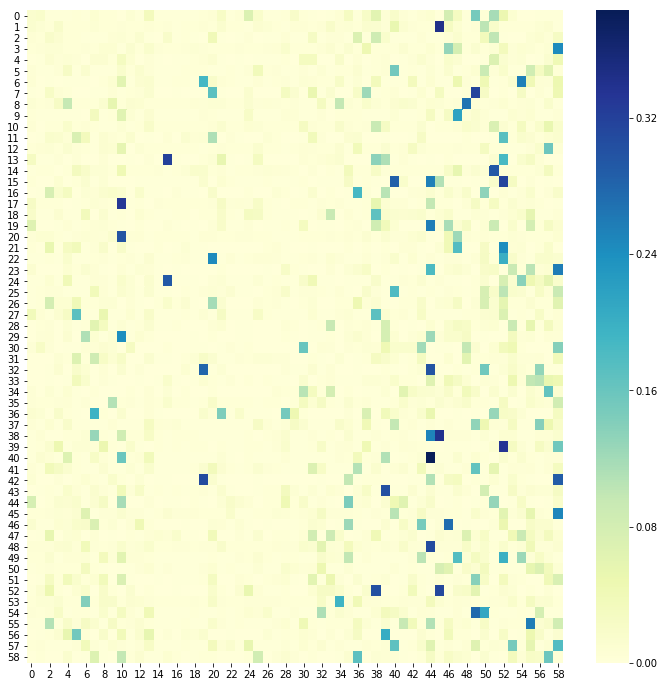

In [44]:
sns.heatmap(np.std(adps, axis=0), cmap="YlGnBu")